<img src="fhnw_ht_e_10mm.jpg" width="480" height="240" align="right"/>
<div style="text-align: left">
<a href="https://orcid.org/0000-0003-4568-9780" ><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-left:.5em;" alt="ORCID iD icon"></a><i>Simon M. Burkhardt</i> 
</div>

# Simulation and Comparison of Spurious Reduction Methods for DDS

### A quantitative analysis using simulation in Python

---


**Abstract** - _With the performance increase of high frequency digital to analog converters, digital synthesizers
continue to replace traditional analog oscillator circuits. Traditional Direct Digital Synthesizers
(DDS) use ROM lookup tables to convert phase to (sinusoidal) amplitude. The phase truncation
occurring in this architecture seriously limits the spectral performance of the generated signal
in the form of spurs. This work uses MATLAB/Simulink to reproduce the frequency errors
widely discussed in literature. The simulation framework is then used to apply various amplitude
treatement algorithms to correct the signal and improve the spurious performance. Furthermore,
the algorithms are compared against each other to ﬁnd the best method in terms of spurious
free dynamic range (SFDR), consumed hardware resources on FPGA and latency. The proposed
design includes an 8 channel polyphase DDS with linear interpolation correction and an expected
SFDR of below −105 dBc._

_Keywords - Direct Digital Synthesis, Bit True Simulation, Spurious Performance Analysis, High Frequency
Signal Generation_

## `I` Introduction

Using digital signal processing to synthesize analog waveforms is a well established method generate a sinewaves of variable frequency. A commonly used architecture is that of the Direct Digital Synthesis (DDS).
One major disadvantage of a DDS system is that a truncation of the phase accumulator needs to be implemented to keep the memory size of the sine look up table (LUT) reasonably small.
This truncation leads to phase errors and inevitably truncation spurs in the spectral domain.
Many signal processing algorithms have been proposed in the past.
Their goal is to minimize truncation spurs while maintaining small LUT sizes.

However, there appears to be no general overview and comparison of the algorithms that anwers the following question quickly:

> "What combination of LUT size and correction algorithm do I need to achieve a signal with $x$ dB spurious free dynamic range?"

This work aims to build a bit-true simulation model in Python to simulate the traditional DDS as well as several spurious correction algorithms in order to compare them in the spectral domain. Not only are the effects of phase truncation and quantization visible, but all the DSP calculations are performed using fixed point arithmetic. 
The example chosen are the DSP48E2 Slices available in Xilinx FPGA, capable of working with a minimum of 18 bits precision.


WIP Issues with this Simulation
- increasing DAC resolution does not reduce noise floor in SFDR (e.g. 150 dB at 24 bit)
- linear interpolation somehow fails for width=14
- dithering not working at all


## `II` Building a Simulation
Import libraries

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
# colors
yellow_light = "#FFC312"
blue_dark    = "#227093"
green_dark   = "#12CBC4"

Global settings for all of the simulations

In [2]:
P = 16            # waveform quanitzation, equal to DAC resolution
N = 32            # total width of the phase accumulator
dsp_width = 18    # DSP precision in bit - compare with Xilinx DSP48E2 "DSP Slice"

fs = 100E+6       # sampling rate
fo = 0.25E6       # desired output signal frequency
T = int(6000)     # number of output samples to be simulated for FFT

### `A` Traditional DDS Design

For reference purposes, let us create an ideal signal that is only affected by quantization of the DAC.

In [3]:
def pure_sin(P, fs, fo, T):
    return (1.0+np.sin(2*np.pi*fo/fs*np.linspace(0,T-1,T)) * 2**(P-1)).astype('int64')

Let us consider the most basic DDS. The LUT consists of $N=2^{W}$ samples representing a full sine wave. Next, the phase accumulator is incremented using the frequency counter word $\mathrm{FCW}={2^{N}\frac{f_S}{f_O}}$. This is then used to derrive the counter value $t$. The truncation of the least significant bits is performed by a bit shift to the right. The remaining most significant bits are then used as the address to the LUT to convert the phase value to an amplitude.

In [4]:
def dds(P, N, M, f_s, f_o, T):
    n_lut = 2**M
    lut_x = np.linspace(0,n_lut-1, n_lut)/n_lut
    # generate LUT with sine values scaled and quantized to the unsigned int type of the DAC resolution
    lut_y = ((1.0+np.sin(2*np.pi*lut_x)) * 2**(P-1)).astype('int64')
    fcw = np.floor( (2**N)*f_o/f_s ).astype('int64')  # calculate FCW
    t = np.linspace(0,T-1, T).astype('int64')             # prepare phase accumulator
    t = t*fcw                                             # sample number x FCW increment
    t = np.mod(t, 2**N)                               # accumulator overflow
    W = (N-M)                                 # truncate to LUT address width
    t_msb = np.right_shift(t, W)                      # convert to LUT address range
    s = lut_y[t_msb]
    return s

In order to compare different DDS algorithms in the frequency domain, we need a function to calculate the spectrum.
For this purpose, the Welch method is chosen. Furthermore, the time series is weighted with the Kaiser-window function parametrized with a $\beta=6$ to achieve a sidelobe suppression of $\approx$ 120 dB. This is important to push the noise floor lower than the smallest spurious frequencies.

In [5]:
def get_welch_psd(s, fs, T):
    # Power Spectrum, Welch, fs=200e6, 0% overlap, running averaging method
    # use Kaiser-Window beta=6 @ 4096 samples to give min. 120 dB sidelobe attenuation
    f,S = sig.welch(s, fs, nperseg=T, window=('kaiser', 6), scaling='spectrum')
    f = f[0:len(f)-1]
    S = S[0:len(S)-1]
    S = np.abs(S)
    S = 10*np.log10(S/np.max(S))
    return f, S

Equiped with this tool, a first verification of the DDS simulation can be performed.

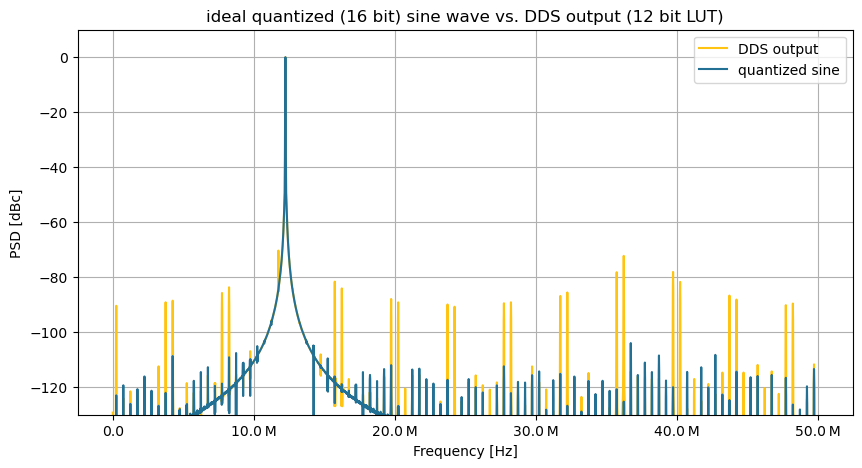

In [6]:
x = dds(16, 32, 12, 100E6, 12.25E6, 6000)
y = pure_sin(16, 100E6, 12.25E6, 6000)
f,X = get_welch_psd(x, 100E6, 6000)
f,Y = get_welch_psd(y, 100E6, 6000)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"ideal quantized (16 bit) sine wave vs. DDS output (12 bit LUT)")
ax.plot(f, X, color=yellow_light, label="DDS output")
ax.plot(f, Y, color=blue_dark,    label="quantized sine")
ax.grid()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("PSD [dBc]")
ax.set_ylim([-130, 10])
ax.legend()
ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
plt.savefig("spec_dds_sine.pdf", format="pdf")

The greatest spurious component is ultimately responsible for the calculation of the spurious free dynamic range (SFDR) which is a common quality measurement of signal sources.
We can verify the above and forthcoming simulations using the amplitude estimation presented in:

> Analog Devices Inc., _"How to Predict the Frequency and Magnitude of the Primary Phase
Truncation Spur in the Output Spectrum of a Direct Digital Synthesizer (DDS)"_, 2016, online: https://www.analog.com/media/en/technical-documentation/application-notes/AN-1396.pdf 

According to this application note, the amplitude of the greatest spurious component is given by:

$S = 20\cdot \log_{10} \left| \frac{\sin{\frac{\pi}{2^L}}}{\sin{\frac{\pi(2^P-1)}{2^L}}} \right|$

where $P$ is the truncated width and $L$ is the index of the least significant '1' bit counting from the MSB.

In [7]:
def predict_dds_sfdr(N, M, f_s, f_o):
    P = M
    fcw = np.floor( (2**N)*f_o/f_s ).astype('int64')
    fcw_bin = np.binary_repr(fcw, N)
    L=0
    for i,b in enumerate(fcw_bin):
        if(b=='1'):
            L=i
    L+=1
    predict_sfdr = 20*np.log10( np.abs( np.sin(np.pi/2**L)/ np.sin( np.pi*(2**P -1)/2**L ) ) )
    return predict_sfdr

Applying the prediction algorithm on the same parameters as the DDS simulation yields a spurious component at -84dB (relative to the carrier) which is the same as the simulation result in the spectrum above.

In [8]:
sfdr_predict = -predict_dds_sfdr(32, 14, 100E6, 12.25E6)
print(f"predicted SFDR: {sfdr_predict:.1f} dB")

predicted SFDR: 84.3 dB


### `B` Piecewise Linear Interpolation

The linear interpolation interpolates between the current LUT value and the proceeding. It connects the two values using a linear slope. This slope is then multiplied by the value of the LSBs of the phase to get a correcting value.

> S. Tang, C. Li and Y. Hou, "_A Suppressing Method for Spur Caused by Amplitude Quantization in DDS,_" in IEEE Access, vol. 7, pp. 62344-62351, 2019, doi: [10.1109/ACCESS.2019.2915677](https://doi.org/10.1109/ACCESS.2019.2915677).

![dds_lin_interpol.png](dds_lin_interpol.png)


In [9]:
def dds_linear_interpol(P, N, M, f_s, f_o, T):
    dspwidth = dsp_width                                  # DSP multiplier width
    n_lut = 2**M
    lut_x = np.linspace(0,n_lut-1, n_lut)/n_lut
    # generate LUT with sine values scaled and quantized to the unsigned int type of the DAC resolution
    lut_y = ((1.0+np.sin(2*np.pi*lut_x)) * 2**(P-1)).astype('int64')
    fcw = np.floor( (2**N)*f_o/f_s ).astype('int64')  # calculate FCW
    t = np.linspace(0,T-1, T).astype('int64')             # prepare phase accumulator
    t = t*fcw                                             # sample number x FCW increment
    t = np.mod(t, 2**N)                               # accumulator overflow
    W = (N-M)                                 # truncate to LUT address width
    t_msb = np.right_shift(t, W)                      # convert to LUT address range
    s = lut_y[t_msb]
    
    # correct signal by applying Linear Interpolation
    lsbmask = (2**W) -1
    t_lsb = np.bitwise_and(t, lsbmask)                    # select only the LSB of the phase
    
    # scale the signal to the DSP multiplier, to use the full dynamic range
    if(W > dspwidth):
        t_lsb = np.right_shift(t_lsb, (W+1)-dspwidth) # truncate if LSBs are larger than DSP resolution
    if(W < dspwidth):
        t_lsb = np.left_shift(t_lsb, dspwidth-(W+1))  # scale up if LSBs are less than DSP resolution
    t_nxt = np.mod(t_msb+1, 2**M)                     # look ahead phase-step
    s_nxt = lut_y[t_nxt]                                  # next value to interpolate to
    slope = s_nxt-s                                       # linear slope (assuming DAC resolution is less than DSP)
    corr = (slope*t_lsb).astype('int64') 
    if(W == dspwidth):
        corr = np.right_shift(corr, dspwidth)               # rescale the DSP values to the range of the DAC
    else:
        corr = np.right_shift(corr, dspwidth-1)               # rescale the DSP values to the range of the DAC
    return s + corr

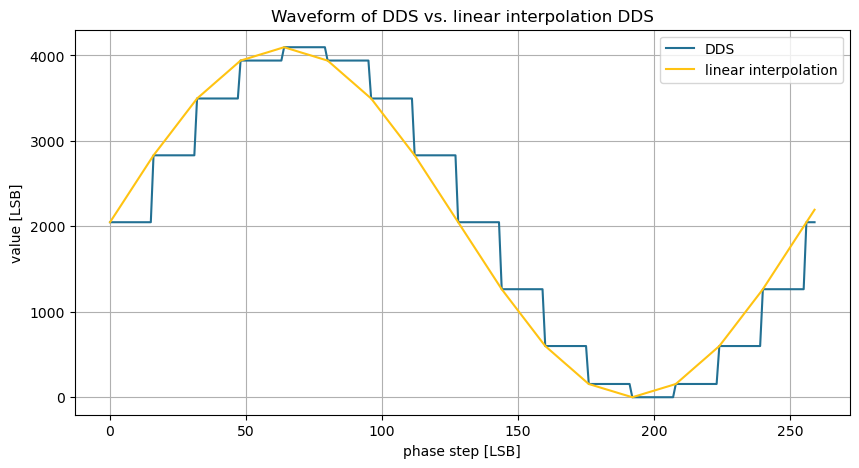

In [10]:
# 12 bit DAC, 9 bit wide phase counter, 4 bit wide LUT address
a = dds(12, 9, 4, 100e3, 0.4e3, 260)
b = dds_linear_interpol(12, 9, 4, 100e3, 0.4e3, 260)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(a, color=blue_dark,    label="DDS")
ax.plot(b, color=yellow_light, label="linear interpolation")

ax.legend()
ax.grid()
ax.set_xlabel("phase step [LSB]")
ax.set_ylabel("value [LSB]")
ax.set_title("Waveform of DDS vs. linear interpolation DDS")
plt.savefig("sig_dds_piecelin.pdf", format="pdf")


### `C` Taylor-Series Interpolation

The Taylor-Series interpolation works similar to the linear interpolation. Instead of a slope between two values, it uses the first derrivative at a given point as the slope. In the case of a sine-function, this results in the need for a second LUT containing the cosine values. If the DDS system is configured to produce a complex I/Q output, then the cosine LUT might already be there. However, there is an additional multiplication required to account for the factor of $2\pi$ which is a biproduct of the first derrivative.

$\sin\left( x \right) \approx \sin\left( k \right) + 2\pi\cdot \left(x-k\right)\cdot \cos\left( k \right)$

This interpolation has previously been implemented in

> J. Zhang, R. Zhang and Y. Dai, _"Design and FPGA implementation of DDS based on waveform compression and Taylor series,"_ 2017 29th Chinese Control And Decision Conference (CCDC), Chongqing, China, 2017, pp. 1301-1306, doi: [10.1109/CCDC.2017.7978718](https://doi.org/10.1109/CCDC.2017.7978718).

For the simulation, let's rewrite the above formula as:

$\sin\left( \Phi \right) \approx \sin\left( \Phi_{MSB} \right) + 2\pi\cdot \Phi_{LSB}\cdot \cos\left( \Phi_{MSB} \right)$

The following figure depicts the signal flow schematic of the implemented simulation.
Note that the gain of $2\pi$ is a multiplication and the execution order of all multiplications is only relevant for retaining precision.

![dds_tay_interpol.png](dds_tay_interpol.png)

In [11]:
def dds_taylor_interpol(P, N, M, f_s, f_o, T):
    dspwidth = dsp_width                                  # DSP multiplier width
    n_lut = 2**M
    lut_x = np.linspace(0,n_lut-1, n_lut)/n_lut
    # generate LUT with sine values scaled and quantized to the unsigned int type of the DAC resolution
    # using a gain of 1.99 because the Taylor Correction overshoots the DAC range
    lut_y = ((np.sin(2*np.pi*lut_x)) * 1.99**(P-1)).astype('int64') 
    # generate LUT with 1st derrivative (cosine)
    lut_z = ((np.cos(2*np.pi*lut_x)) * 1.99**(P-1)).astype('int64')
    fcw = np.floor( (2**N)*f_o/f_s ).astype('int64')  # calculate FCW
    t = np.linspace(0,T-1, T).astype('int64')             # prepare phase accumulator
    t = t*fcw                                             # sample number x FCW increment
    t = np.mod(t, 2**N)                               # accumulator overflow
    W = (N-M)                                 # truncate to LUT address width
    t_msb = np.right_shift(t, W)                      # convert to LUT address range
    s = lut_y[t_msb] + 2**(P-1)

    # correct signal by applying Taylor-Series Interpolation
    lsbmask = (2**W) -1
    t_lsb = np.bitwise_and(t, lsbmask)                    # only the LSB

    # use full DSP dynamic range and scale the LSBs to maximum range
    if( W < dspwidth ):
        t_lsb = np.left_shift(t_lsb, dspwidth-W)
    if( W > dspwidth ):
        t_lsb = np.right_shift(t_lsb, W-dspwidth)

    pifix = int(np.pi*2**(dspwidth-2))                    # representation of 2pi constant in dspwidth bits
    t_lsb = (t_lsb*pifix).astype('int64')                 # length of result is now 2 * dspwidth
    t_lsb = np.right_shift(t_lsb, dspwidth)               # resize back to dspwidth for next operation
    slope = lut_z[t_msb]
    corr = (slope * t_lsb).astype('int64')                # length of result is now 2 * dspwidth 
    corr = np.right_shift(corr, dspwidth+M-3)         # resize back to dspwidth

    s = np.clip(s + corr, 0, 2**P)                    # "saturate" --> prevent under and overflow of DAC values
    return s

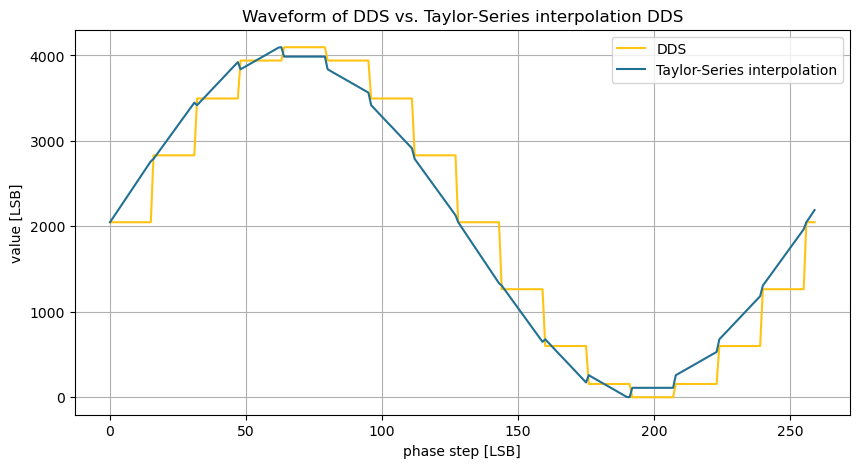

In [12]:
# 12 bit DAC, 9 bit wide phase counter, 4 bit wide LUT address
a = dds(12, 9, 4, 100e3, 0.4e3, 260)
b = dds_taylor_interpol(12, 9, 4, 100e3, 0.4e3, 260)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(a, color=yellow_light, label="DDS")
ax.plot(b, color=blue_dark,    label="Taylor-Series interpolation")

ax.legend()
ax.grid()
ax.set_xlabel("phase step [LSB]")
ax.set_ylabel("value [LSB]")
ax.set_title("Waveform of DDS vs. Taylor-Series interpolation DDS")
plt.savefig("sig_dds_taylor.pdf", format="pdf")

Note how the Taylor-Series correction tends to overshoot towards the areas where the slope changes greatly.

### `D` Phase-Dithering

Sometimes overall noise is less important than the energy in the spurious frequencies.
Here, the Phase-Dithering approach offers a cheap solution to spread the spurious energy into the noise.
This effectively reduces spurious amplitudes at the cost of a smaller signal to noise ratio (SNR).



In [13]:
def dds_phase_dither(P, N, M, f_s, f_o, T, debug_phase=0):
    n_lut = 2**M
    lut_x = np.linspace(0,n_lut-1, n_lut)/n_lut
    lut_y = ((1.0+np.sin(2*np.pi*lut_x)) * 2**(P-1)).astype('int64')
    fcw = np.floor( (2**N)*f_o/f_s ).astype('int64')  # calculate FCW
    t = np.linspace(0,T-1, T).astype('int64')             # prepare phase accumulator
    t = t*fcw                                             # sample number x FCW increment
    t = np.mod(t, 2**N)                               # accumulator overflow
    W = (N-M)                                 # truncate to LUT address width
    
    # dither the phase by adding a random number
    # the dithering gain balances noise level vs. spur suppression effect
    dith_gain = int((2**W)/32) 
    dither = np.random.randint(0,2**5,len(t))             # LFSR with 5-bit output as PRNG
    dither = dither * dith_gain
    t_dit = np.mod(t+dither, 2**N)                    # add the dithering signal to the phase accumulator output
    t_msb = np.right_shift(t_dit, W)                  # convert to LUT address range
    s = lut_y[t_msb]
    
    if(debug_phase):
        return (s, t_msb)                                 # for plotting the dithered phase
    return s

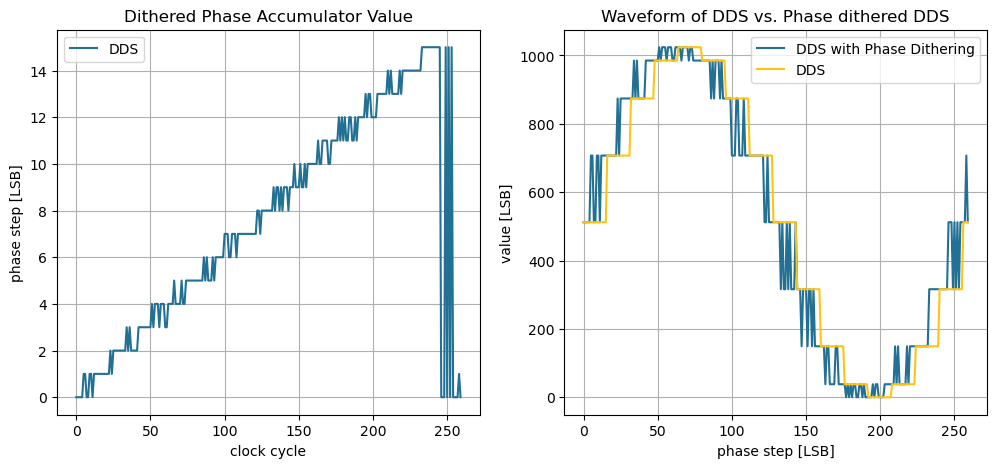

In [14]:
# 12 bit DAC, 9 bit wide phase counter, 4 bit wide LUT address
a = dds(10, 12, 4, 100e3, 0.4e3, T)
b,p = dds_phase_dither(10, 12, 4, 100e3, 0.4e3, T, 1)
f,A = get_welch_psd(a, 100e3, T)
f,B = get_welch_psd(b, 100e3, T)

fig, (ax2, ax1) = plt.subplots(1,2, figsize=(12, 5))
ax2.set_title("Dithered Phase Accumulator Value")
ax2.plot(p[:260], color=blue_dark, label="DDS")
ax2.set_xlabel("clock cycle")
ax2.set_ylabel("phase step [LSB]")
ax2.legend()
ax2.grid()

ax1.set_title("Waveform of DDS vs. Phase dithered DDS")
ax1.plot(b[:260], color=blue_dark,    label="DDS with Phase Dithering")
ax1.plot(a[:260], color=yellow_light, label="DDS")
ax1.set_xlabel("phase step [LSB]")
ax1.set_ylabel("value [LSB]")
ax1.legend()
ax1.grid()

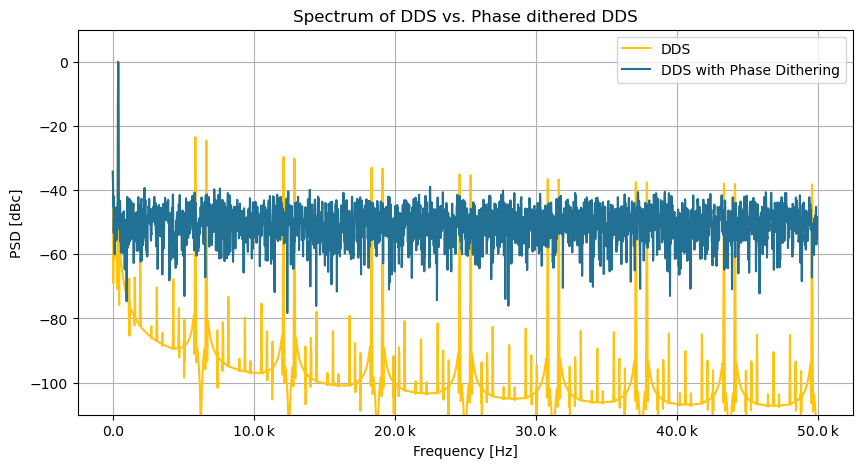

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Spectrum of DDS vs. Phase dithered DDS")
ax.plot(f, A, color=yellow_light, label="DDS")
ax.plot(f, B, color=blue_dark,    label="DDS with Phase Dithering")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("PSD [dBc]")
ax.legend()
ax.grid()
ax.set_ylim([-110, 10])
ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
plt.savefig("spec_dds_phasdither.pdf", format="pdf")

Note the disappearance of truncation spurs and the severely worse noise situation.

In [16]:
def get_sfdr(x):
    peaks = []
    x = x - np.mean(x)  # remove any DC offset
    prev = [np.min(x), np.min(x), np.min(x), np.min(x), np.min(x), np.min(x)]
    # find all peaks
    for s in x:
        
        if((s < prev[0]) and (prev[0] < prev[1]) and (prev[1] > prev[2]) and (prev[2] > prev[3])):
            # x peaked at x[n-1] if x[n-1] is greater than x[n-2] and x[n]
            peaks.append(prev[1])
        prev[3] = prev[2]
        prev[2] = prev[1]
        prev[1] = prev[0]
        prev[0] = s
    # find the two biggest peaks and calculate their distance
    peaks = np.array(peaks)
    idx = np.argsort(peaks)
    peaks = peaks[idx]
    sfdr = peaks[-1] - peaks[-2]
    return sfdr

## `III` Simulating various LUT widths

### `A` Quantization with 16 bit DAC

In [17]:
f_axs = np.linspace(0,fs, int(T/2))

prd_sfdr = []
dds_frq = []; lin_frq = []; tay_frq = []; dit_frq = [];
dds_sig = []; lin_sig = []; tay_sig = []; dit_sig = [];
dds_fft = []; lin_fft = []; tay_fft = []; dit_fft = [];
dds_sfdr = []; lin_sfdr = []; tay_sfdr = []; dit_sfdr = [];
dds_snr = [];  lin_snr = []; tay_snr = []; dit_snr = [];
for M in range(3, 20):
    s = dds(P, N, M, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    dds_fft.append(S)
    dds_sig.append(s)
    dds_frq.append(f)
    s = dds_linear_interpol(P, N, M, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    lin_fft.append(S)
    lin_sig.append(s)
    lin_frq.append(f)
    s = dds_taylor_interpol(P, N, M, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    tay_fft.append(S)
    tay_sig.append(s)
    tay_frq.append(f)
    s = dds_phase_dither(P, N, M, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    dit_fft.append(S)
    dit_sig.append(s)
    dit_frq.append(f)
    prd_sfdr.append(predict_dds_sfdr(N, M, fs, fo))

for i in range(len(dds_fft)):
    dds_sfdr.append(-get_sfdr(dds_fft[i]))
    lin_sfdr.append(-get_sfdr(lin_fft[i]))
    tay_sfdr.append(-get_sfdr(tay_fft[i]))
    dit_sfdr.append(-get_sfdr(dit_fft[i]))

sin_sig = pure_sin(P, fs, fo, T)
f,S = get_welch_psd(sin_sig, fs, T)
sin_fft = S
sin_frq = f
sin_sfdr = -get_sfdr(sin_fft)

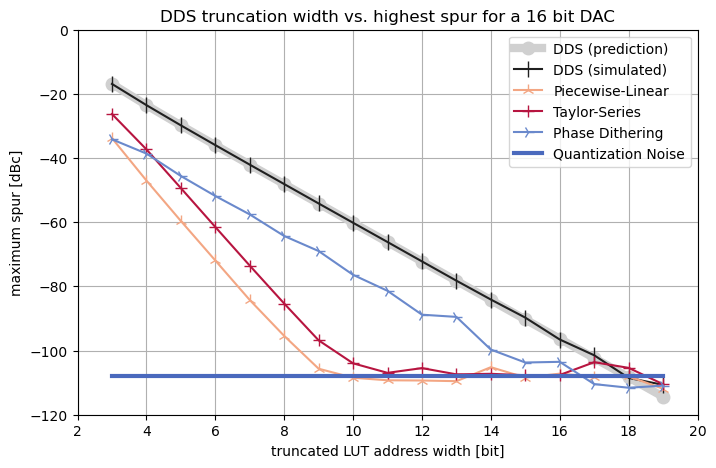

In [18]:
trunc = np.linspace(3, len(dds_sfdr)+2, len(dds_sfdr))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trunc, prd_sfdr, marker="o", markersize=9, color="#d0d0d0", linewidth=6, label="DDS (prediction)")
ax.plot(trunc, dds_sfdr, marker="|", markersize=12, color="#202020", label="DDS (simulated)")
ax.plot(trunc, lin_sfdr, marker="2", markersize=9, color="#f3a683", label="Piecewise-Linear")
ax.plot(trunc, tay_sfdr, marker="+", markersize=9, color="#b71540", label="Taylor-Series")
ax.plot(trunc, dit_sfdr, marker="4", markersize=9, color="#6a89cc", label="Phase Dithering")
ax.plot([3,19], [sin_sfdr, sin_sfdr], color="#4a69bd", linewidth=3, label="Quantization Noise")

ax.legend()
ax.grid()
ax.set_xlabel("truncated LUT address width [bit]")
ax.set_ylabel("maximum spur [dBc]")
ax.set_ylim([-120, 0])
ax.set_title("DDS truncation width vs. highest spur for a 16 bit DAC")
ax.set_xticks(np.arange(2, 21, 2));
plt.savefig("algorithms_sfdr_16bit.pdf", format="pdf")

### `B` Comparison With Prior Work

The results above can be verified by comparing them to other examples in the literature.

> J. M. P. Langlois and D. Al-Khalili, "_Novel approach to the design of direct digital frequency synthesizers based on linear interpolation,_" in IEEE Transactions on Circuits and Systems II: Analog and Digital Signal Processing, vol. 50, no. 9, pp. 567-578, Sept. 2003, doi: [10.1109/TCSII.2003.815020](https://doi.org/10.1109/TCSII.2003.815020)

implements a quarter-wave compression of the LUT based on the symmetries of the sine-wave. 
It uses $2$ bits of the phase accumulators MSBs to perform a quarter-wave compression of the sine wave.
Therefore, the truncation is expressed differently. For their first simulation they use a LUT with 32 segments 
or $5$ bits of the phase MSB. However, $2$ more bits are required to perform the decompression effectively resulting in an equivalent truncation width of $7$ bits.

Their simulation in MATLAB strivesa to achieve $84$ dB SFDR with a Piecewise-Linear interpolation on a DDS system with a $5+2=7$ bit wide LUT address. The simulation results in an SFDR or $84.2093$ dB. Checking the figure above, on the x-axis yields a maximum spurious magnitude at $\approx 84$ dBc.

The second simulaton is based on a synthesized deisgn that uses $6+2=8$ bits of LUT address resulting in an SFDR of $96.2607$ dB. Again, the comparison with the figure above shows an approximate spurious magnitude of $\approx 96$ dBc

In [19]:
print(f"In literature 84.21 dB vs. this python simulation SFDR {-lin_sfdr[4]:.02f} dB for 7 bit LUT")
print(f"In literature 96.26 dB vs. this python simulation SFDR {-lin_sfdr[5]:.02f} dB for 8 bit LUT")

In literature 84.21 dB vs. this python simulation SFDR 84.24 dB for 7 bit LUT
In literature 96.26 dB vs. this python simulation SFDR 95.44 dB for 8 bit LUT



### `C` Quantization with 24 bit DAC



In [20]:
M = 24

In [21]:
f_axs = np.linspace(0,fs, int(T/2))

prd_sfdr = []
dds_frq = []; lin_frq = []; tay_frq = []; dit_frq = [];
dds_sig = []; lin_sig = []; tay_sig = []; dit_sig = [];
dds_fft = []; lin_fft = []; tay_fft = []; dit_fft = [];
dds_sfdr = []; lin_sfdr = []; tay_sfdr = []; dit_sfdr = [];
dds_snr = [];  lin_snr = []; tay_snr = []; dit_snr = [];
for W in range(3, 20):
    s = dds(M, N, W, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    dds_fft.append(S)
    dds_sig.append(s)
    dds_frq.append(f)
    s = dds_linear_interpol(M, N, W, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    lin_fft.append(S)
    lin_sig.append(s)
    lin_frq.append(f)
    s = dds_taylor_interpol(M, N, W, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    tay_fft.append(S)
    tay_sig.append(s)
    tay_frq.append(f)
    s = dds_phase_dither(M, N, W, fs, fo, T)
    f,S = get_welch_psd(s, fs, T)
    dit_fft.append(S)
    dit_sig.append(s)
    dit_frq.append(f)
    prd_sfdr.append(predict_dds_sfdr(N, W, fs, fo))

for i in range(len(dds_fft)):
    dds_sfdr.append(-get_sfdr(dds_fft[i]))
    lin_sfdr.append(-get_sfdr(lin_fft[i]))
    tay_sfdr.append(-get_sfdr(tay_fft[i]))
    dit_sfdr.append(-get_sfdr(dit_fft[i]))

sin_sig = pure_sin(M, fs, fo, T)
f,S = get_welch_psd(sin_sig, fs, T)
sin_fft = S
sin_frq = f
sin_sfdr = -get_sfdr(sin_fft)

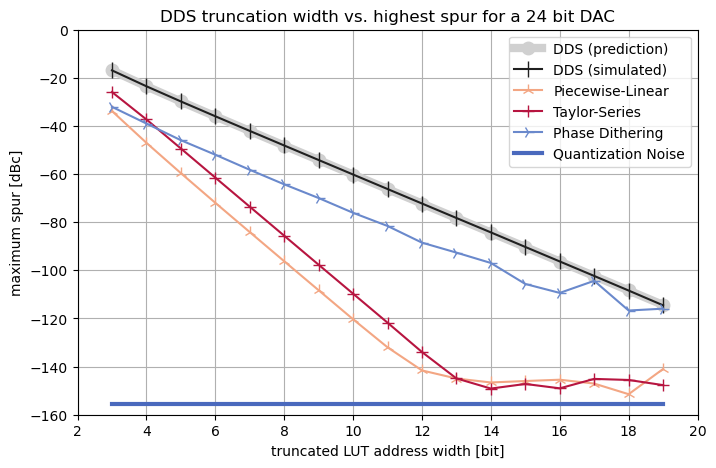

In [22]:
trunc = np.linspace(3, len(dds_sfdr)+2, len(dds_sfdr))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trunc, prd_sfdr, marker="o", markersize=9, color="#d0d0d0", linewidth=6, label="DDS (prediction)")
ax.plot(trunc, dds_sfdr, marker="|", markersize=12, color="#202020", label="DDS (simulated)")
ax.plot(trunc, lin_sfdr, marker="2", markersize=9, color="#f3a683", label="Piecewise-Linear")
ax.plot(trunc, tay_sfdr, marker="+", markersize=9, color="#b71540", label="Taylor-Series")
ax.plot(trunc, dit_sfdr, marker="4", markersize=9, color="#6a89cc", label="Phase Dithering")
ax.plot([3,19], [sin_sfdr, sin_sfdr], color="#4a69bd", linewidth=3, label="Quantization Noise")

ax.legend()
ax.grid()
ax.set_xlabel("truncated LUT address width [bit]")
ax.set_ylabel("maximum spur [dBc]")
ax.set_ylim([-160, 0])
ax.set_title("DDS truncation width vs. highest spur for a 24 bit DAC")
ax.set_xticks(np.arange(2, 21, 2));
plt.savefig("algorithms_sfdr_24bit.pdf", format="pdf")